In [48]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interact_manual, FloatSlider, IntSlider
import argparse
import os

sns.set()

In [2]:
# images are 32 by 32 pixles
img_size = 32
# data contrains sybols represeting: lower case and uppercase letters, and numbers 0-9
num_classes = 26 + 26 + 10
# there are 1016 fonts in the data set
num_fonts = 1016
# total number of samples
num_samples = num_fonts * num_classes

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [41]:
def reshape_font_data(font_data):
    font_matrix = font_data.reshape(1984, 32)
    image = np.zeros(shape=(img_size*8, img_size*8))

    for i in range(8):
        part = font_matrix[i*32*8:(i+1)*32*8, :]
        rows = part.shape[0]
        image[:rows, i*32:(i+1)*32] = part
    return image

def reshape_and_plot_image(font_vector, title='', figsize=(12, 12), fontsize=16):
    image = reshape_font_data(font_vector)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(title, fontsize=fontsize)
    
    return ax

In [5]:
print("Loading fonts data.")
font_data = np.load('../data/processed/font_vectors_small.npz')
X = font_data['data']
print("Done.")
n_samples, original_dim = X.shape

y = np.arange(n_samples)

Loading fonts data.
Done.


In [8]:
reshaped_data = np.zeros((num_fonts, img_size * num_classes, img_size, 1))

for i in range(num_fonts):
    reshaped_data[i, :, :, :] = X[i].reshape(img_size * num_classes, img_size, 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(reshaped_data, y, 
                                                    shuffle=True, 
                                                    random_state=0)

In [10]:
x_train[0].shape

(1984, 32, 1)

In [11]:
# network parameters
input_shape = x_train[0].shape
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 8
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 1984, 32, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 992, 16, 32)  320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 496, 8, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 253952)       0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [12]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 253952)            2285568   
_________________________________________________________________
reshape_1 (Reshape)          (None, 496, 8, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 992, 16, 64)       36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 1984, 32, 32)      18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 1984, 32, 1)       289       
Total params: 2,341,249
Trainable params: 2,341,249
Non-trainable params: 0
_________________________________________________________________


In [28]:
models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
if True:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_cnn_fonts.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 1984, 32, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 8), (None, 8), (N 4082336   
_________________________________________________________________
decoder (Model)              (None, 1984, 32, 1)       2341249   
Total params: 6,423,585
Trainable params: 6,423,585
Non-trainable params: 0
_________________________________________________________________
Train on 762 samples, validate on 254 samples
Epoch 1/30
762/762 [==============================] - 161s 212ms/step - loss: 1664.2249 - val_loss: 185.9663
Epoch 2/30
762/762 [==============================] - 141s 185ms/step - loss: 148.6440 - val_loss: 113.0236
Epoch 3/30
762/762 [==============================] - 143s 187ms/step - loss: 109.7279 - val_loss: 98.3597
Epoch 4/30
762/762 [======

In [14]:
WEIGHTS_PATH = 'vae_cnn_fonts.h5'

if WEIGHTS_PATH:
    vae.load_weights(WEIGHTS_PATH)

In [50]:
z_learnt = encoder.predict(x_train)[0]

In [59]:
z_learnt[:, 1].min(), z_learnt[:, 2].max()

(0.02223403, -0.0138251465)

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83

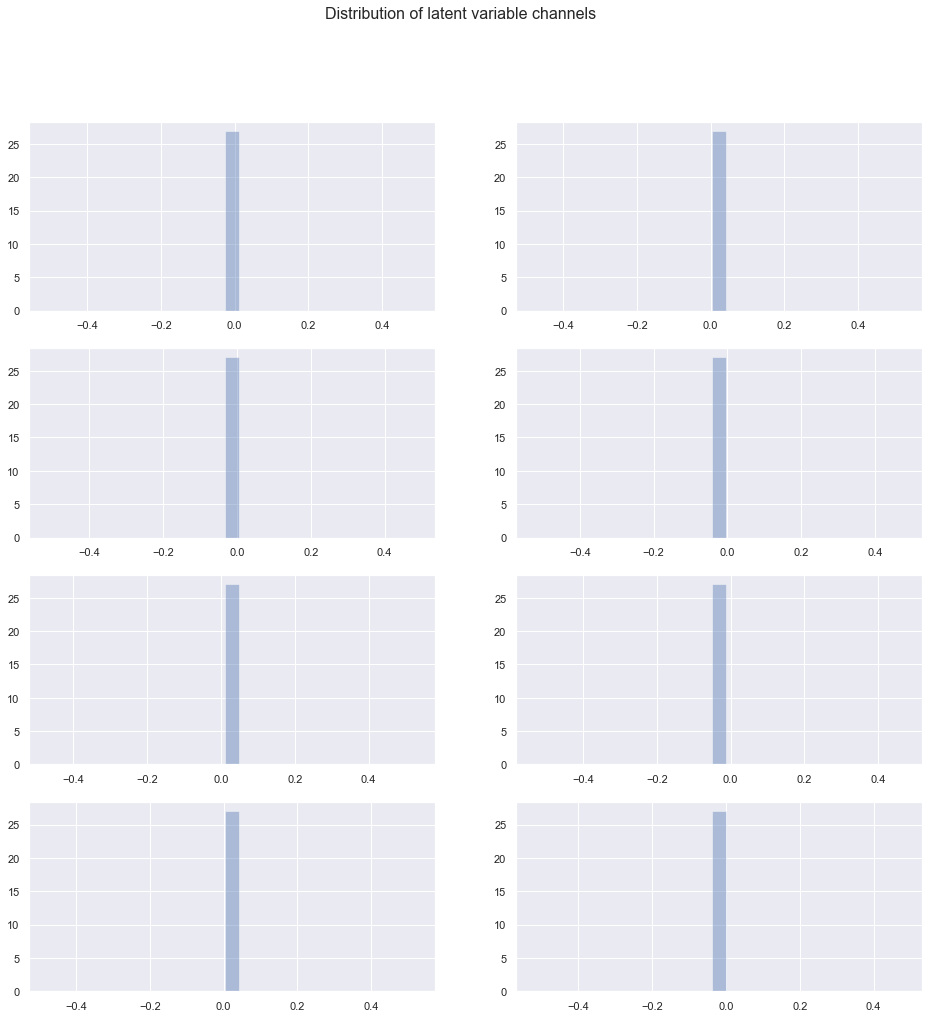

In [51]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))

for i, ax in enumerate(axes.ravel()):
    sns.distplot(z_learnt[:, i], ax=ax)
    
fig.suptitle('Distribution of latent variable channels', fontsize=16)
pass

In [15]:
z_sample = np.random.normal(scale=5, size=(1, latent_dim))
x_decoded = decoder.predict(z_sample)

Text(0.5,1,'Generated font')

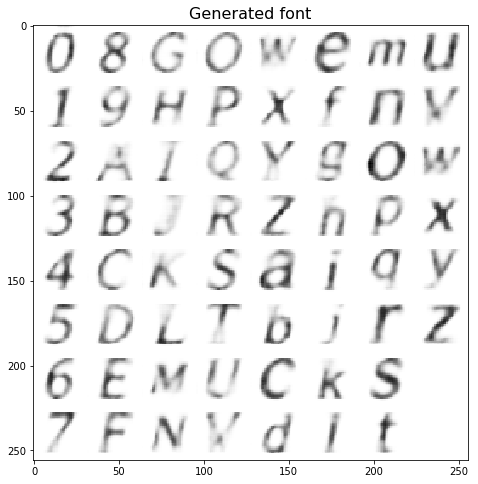

In [45]:
plt.figure(figsize=(8, 8))
plt.imshow(reshape_font_data(x_decoded[0]), cmap=plt.cm.gray_r) 

plt.title('Generated font', fontsize=16)
#plt.savefig('../figures/generated_font_3.png', bbox_inches='tight')

In [64]:
plt.rcParams['figure.figsize'] = 12, 12

def generate_font(z0, z1, z2, z3, z4, z5, z6, z7):
    z_sample = np.array([[z0, z1, z2, z3, z4, z5, z6, z7]])
    
    x_decoded = decoder.predict(z_sample)
    image = reshape_font_data(x_decoded[0])
    
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('Generated font', fontsize=16)
    plt.grid(False)
    plt.show()

lower, upper = -5, 5
step = 0.01
im = interact_manual(generate_font, 
                     z0=FloatSlider(min=lower, max=upper, step=step),
                     z1=FloatSlider(min=lower, max=upper, step=step),
                     z2=FloatSlider(min=lower, max=upper, step=step),
                     z3=FloatSlider(min=lower, max=upper, step=step),
                     z4=FloatSlider(min=lower, max=upper, step=step),
                     z5=FloatSlider(min=lower, max=upper, step=step),
                     z6=FloatSlider(min=lower, max=upper, step=step),
                     z7=FloatSlider(min=lower, max=upper, step=step))

im.widget.children[-2].description = 'Generate font'

interactive(children=(FloatSlider(value=0.0, description='z0', max=5.0, min=-5.0, step=0.01), FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0, step=0.01), FloatSlider(value=0.0, description='z2', max=5.0, min=-5.0, step=0.01), FloatSlider(value=0.0, description='z3', max=5.0, min=-5.0, step=0.01), FloatSlider(value=0.0, description='z4', max=5.0, min=-5.0, step=0.01), FloatSlider(value=0.0, description='z5', max=5.0, min=-5.0, step=0.01), FloatSlider(value=0.0, description='z6', max=5.0, min=-5.0, step=0.01), FloatSlider(value=0.0, description='z7', max=5.0, min=-5.0, step=0.01), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))